# Import Libraries

In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Load names.txt file

In [57]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

# Mapping charts into unique ids

In [58]:
chars = sorted(set(''.join(words)))
ch2i = {ch: i+1 for i, ch in enumerate(chars)}
ch2i['.'] = 0
i2ch = {i: ch for ch, i in ch2i.items()}
i2ch

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# Splitting data into train, validation and test set

In [59]:
def build_dataset(words, block_size=3):
    X, y = [], []

    for w in words:
        context = [0] * (block_size - 1) + [ch2i[w[0]]]
        for ch in w[1:] + '.':
            ch_id = ch2i[ch]
            X.append(context)
            y.append(ch_id)
            context = context[1:] + [ch_id]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y

random.seed(42)
random.shuffle(words)
split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))

block_size = 8
X_train, y_train = build_dataset(words[:split1], block_size)
X_valid, y_valid = build_dataset(words[split1:split2], block_size)
X_test, y_test = build_dataset(words[split2:], block_size)

torch.Size([156999, 8]) torch.Size([156999])
torch.Size([19452, 8]) torch.Size([19452])
torch.Size([19662, 8]) torch.Size([19662])


In [60]:
for x, y in zip(X_train[:20], y_train[:20]):
    print(''.join(i2ch[ix.item()] for ix in x), '-->', i2ch[y.item()])

.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e
...xavie --> n
..xavien --> .
.......j --> o


# Model

In [61]:
# -------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -------------------------------------------------------------------------------------
class FlattenConsequtive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -------------------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# -------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [62]:
torch.manual_seed(42)

In [63]:
vocab_size = len(ch2i)
n_embd = 10
n_hidden = 64
n_flatten = 2

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsequtive(n_flatten), Linear(n_embd * n_flatten, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsequtive(n_flatten), Linear(n_hidden * n_flatten, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsequtive(n_flatten), Linear(n_hidden * n_flatten, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

20073


# Check the dimensions of the layers

In [64]:
ix = torch.randint(0, X_train.shape[0], (4,))
X_batch, y_batch = X_train[ix], y_train[ix]
logits = model(X_batch)
print(X_batch.shape)
print(X_batch)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0, 14, 25, 12],
        [ 0,  0,  0,  0,  0,  0, 13,  9],
        [ 0,  0,  0,  0,  7,  1, 13,  1],
        [ 0,  0,  1, 14,  7,  5, 12, 12]])


In [65]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsequtive : (4, 4, 20)
Linear : (4, 4, 64)
BatchNorm1d : (4, 4, 64)
Tanh : (4, 4, 64)
FlattenConsequtive : (4, 2, 128)
Linear : (4, 2, 64)
BatchNorm1d : (4, 2, 64)
Tanh : (4, 2, 64)
FlattenConsequtive : (4, 128)
Linear : (4, 64)
BatchNorm1d : (4, 64)
Tanh : (4, 64)
Linear : (4, 27)


# Train Model

In [66]:
n_steps = 200000
batch_size = 32
lossi = []

for i in range(n_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, y_batch = X_train[batch_ids], y_train[batch_ids]

    logits = model(X_batch)
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{n_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3001
  10000/ 200000: 2.2544
  20000/ 200000: 2.2299
  30000/ 200000: 1.9232
  40000/ 200000: 1.7965
  50000/ 200000: 1.7603
  60000/ 200000: 2.0326
  70000/ 200000: 1.8035
  80000/ 200000: 1.9003
  90000/ 200000: 2.2602
 100000/ 200000: 1.4161
 110000/ 200000: 1.8284
 120000/ 200000: 1.5908
 130000/ 200000: 2.0807
 140000/ 200000: 2.2177
 150000/ 200000: 2.1788
 160000/ 200000: 1.3696
 170000/ 200000: 1.9021
 180000/ 200000: 2.2013
 190000/ 200000: 1.8910


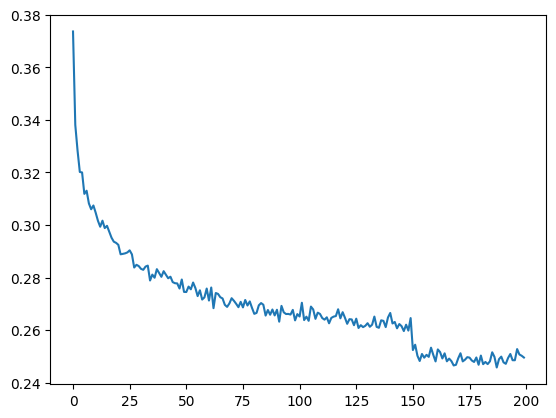

In [68]:
loss_mean = torch.tensor([lossi]).view(-1, 1000).mean(1)
plt.plot(loss_mean)
plt.show()

In [69]:
for layer in model.layers:
    layer.training = False

In [71]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('valid')

train 1.7459758520126343
valid 1.8646570444107056


# Model Inference

In [89]:
for _ in range(20):
    out = []
    first_char = torch.randint(1, len(ch2i), (1,)).item()
    context = [0] * (block_size - 1) + [first_char]
    out.extend(context[block_size-2:])
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(i2ch[i] for i in out))

.wrens.
.veriyanna.
.brinn.
.tarriana.
.inai.
.yashir.
.ajesen.
.fawcen.
.zaylee.
.testyn.
.joskar.
.brihan.
.alisha.
.giraque.
.viminda.
.oszia.
.armane.
.jeylen.
.jerrick.
.vian.
